In [1]:
from dotenv import load_dotenv
load_dotenv("../.env")

True

In [2]:
from langgraph.graph import StateGraph, END, START
from langchain_core.prompts import ChatPromptTemplate
from langchain.chat_models import init_chat_model
from langgraph.types import interrupt

import os 
project_root = os.path.dirname(os.path.abspath(os.getcwd()))
os.chdir(project_root)
# tools
from tools.tools import get_email_tool, email_fetch_feedback_tool
# schemas
from py_files.schemas import EmailItem, ParsedQuery, EmailFetchInput, EmailFetchOutput, UserChoice
# states
from py_files.states import EmailAgentState
# functions 
from py_files.functions import load_prompts, parse_query, fetch_email, should_retry, categorize_user_response

In [7]:
# 노드들
def parse_query_node(state : EmailAgentState) -> EmailAgentState:
    """쿼리 파싱 노드(일반 함수)"""
    try:
        parsed_query = parse_query(state["query"])
        print("쿼리 파싱 완료 !")
        return {**state, "parsed_query" : parsed_query, "status" : "QUERY_PARSED"}
    except Exception as e:
        return {**state, "error" : str(e), "status" : "ERROR"}

def collect_email_node(state : EmailAgentState) -> EmailAgentState:
    """이메일 수집 노드(tool)"""
    try:
        all_emails = get_email_tool.invoke({})
        print("이메일 가져오기 완료 !")
        return {**state, "all_emails" : all_emails, "status" : "EMAIL_COLLECTED"}
    except Exception as e:
        return {**state, "error" : str(e), "status" : "ERROR"}

def fetch_email_node(state : EmailAgentState) -> EmailAgentState:
    """이메일 검색 노드(tool + 일반 함수)"""
    try:
        # 일반 함수 - 쿼리 기반 메일 검색
        fetched_email = fetch_email(state["parsed_query"], state["all_emails"])

        return {**state, "fetched_email" : fetched_email, "status" : "FETCHED_EMAIL"}
    except Exception as e:
        return {**state, "error" : str(e), "status" : "ERROR"}
    
def email_fetch_feedback_node(state : EmailAgentState) -> EmailAgentState:
    """이메일 검색 결과 피드백 노드(tool)"""
    # 이메일 검색 결과가 없다면.. 
    if "fetched_email" not in state:
        print("이메일 검색 결과가 없습니다..")
        return {**state, "status" : "ERROR", "error" : "No email fetched"}

    email = state["fetched_email"]
    print("[사용자 확인 단계]")

    message = f"""
찾은 이메일:
--------------------------------
제목 : {email.subject}
보낸 사람 : {email.sender}
내용 : {email.content}
--------------------------------

찾고 계신 게 이 이메일이 맞나요?
    """
    user_input : str = interrupt({"ask" : "email_confirm", "message" : message})
    
    user_input = (user_input or "").strip()
    print("사용자 응답 분석 중...")
    try:
        user_choice = categorize_user_response(user_input)

        if user_choice.kind == "CONFIRM":
            print("확인 - 이 이메일로 진행하겠습니다!")
        else:
            print("재검색 - 다른 이메일을 찾아보겠습니다..")
        return {**state, "user_feedback" : user_choice, "user_message" : user_input, "status" : "RECEIVED_FEEDBACK"}
    except Exception as e:
        print(f"오류 발생: {str(e)}")
        print("기본값 - 다시 검색하겠습니다..")
        user_choice = UserChoice(kind = "RETRY", goto = "email_fetcher")

        return {**state, "user_feedback" : user_choice, "user_message" : user_input, "status" : "RECEIVED_FEEDBACK"}

def completed_node(state : EmailAgentState) -> EmailAgentState:
    """완료 노드"""
    return {**state, "status" : "COMPLETED"}

def error_node(state : EmailAgentState) -> EmailAgentState:
    """오류 노드"""
    return {**state, "status" : "ERROR"}

In [15]:
def email_fetcher_agent():
    """이메일 검색 에이전트"""
    workflow = StateGraph(EmailAgentState)

    # 노드 추가
    workflow.add_node("query_parser", parse_query_node)
    workflow.add_node("email_collector", collect_email_node)
    workflow.add_node("email_fetcher", fetch_email_node)
    workflow.add_node("email_fetch_feedback", email_fetch_feedback_node)
    workflow.add_node("completed", completed_node)
    workflow.add_node("error", error_node)

    # 엣지 추가
    workflow.add_edge("query_parser", "email_collector")
    workflow.add_edge("email_collector", "email_fetcher")
    workflow.add_edge("email_fetcher", "email_fetch_feedback")

    # 조건부 엣지 추가
    workflow.add_conditional_edges(
        "email_fetch_feedback",
        should_retry,
        {
            "completed" : "completed",
            "email_fetcher" : "email_fetcher",
            "error" : "error"
        }
    )
    
    workflow.add_edge("completed", END)
    workflow.add_edge("error", END)

    workflow.set_entry_point("query_parser")

    return workflow.compile()

✅ 워크플로우 다이어그램이 'email_agent_workflow.png'로 저장되었습니다!


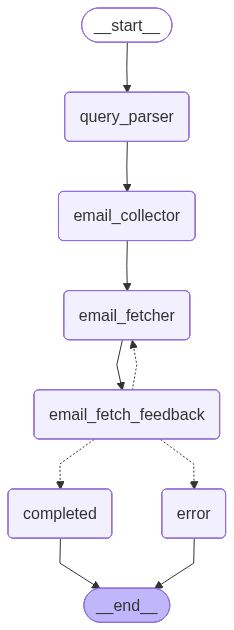

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xe2\x01\xd8ICC_PROFILE\x00\x01\x01\x00\x00\x01\xc8\x00\x00\x00\x00\x040\x00\x00mntrRGB XYZ \x07\xe0\x00\x01\x00\x01\x00\x00\x00\x00\x00\x00acsp\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\xf6\xd6\x00\x01\x00\x00\x00\x00\xd3-\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\tdesc\x00\x00\x00\xf0\x00\x00\x00$rXYZ\x00\x00\x01\x14\x00\x00\x00\x14gXYZ\x00\x00\x01(\x00\x00\x00\x14bXYZ\x00\x00\x01<\x00\x00\x00\x14wtpt\x00\x00\x01P\x00\x00\x00\x14rTRC\x00\x00\x01d\x00\x00\x00(gTRC\x00\x00\x01d\x00\x00\x00(bTRC\x00\x00\x01d\x00\x00\x00(cprt\x00\x00\x01\x8c\x00\x00\x00<mluc\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x0cenUS\x00\x00\x00\x08\x00\x00\x00\x1c\x00s\x00R\x00G\x00BXYZ \x00\x00\x00\x00

In [14]:
def save_agent_diagram():
    """에이전트 워크플로우를 PNG 이미지로 저장"""
    
    agent = email_fetcher_agent()
    
    try:
        # PNG 이미지로 저장
        from IPython.display import Image, display
        
        # 이미지 생성 및 저장
        img_data = agent.get_graph().draw_mermaid_png()
        
        # 파일로 저장
        with open("email_agent_workflow.png", "wb") as f:
            f.write(img_data)
        
        print("✅ 워크플로우 다이어그램이 'email_agent_workflow.png'로 저장되었습니다!")
        
        # Jupyter에서 이미지 표시
        display(Image(img_data))
        
        return img_data
        
    except ImportError:
        print("❌ 이미지 생성을 위해 추가 패키지가 필요합니다:")
        print("pip install pygraphviz")
        return None
    except Exception as e:
        print(f"❌ 이미지 저장 오류: {str(e)}")
        return None

# 이미지 저장
save_agent_diagram()

# 🚀 Responses API 적용 버전

현재 코드에서 **3개의 LLM 호출 지점**에 Responses API를 적용할 수 있습니다:

1. **`parse_query()`** - 쿼리 파싱
2. **`fetch_email()`** - 이메일 검색  
3. **`categorize_user_response()`** - 사용자 응답 분류

아래에서 Responses API를 사용한 개선된 버전을 구현해보겠습니다.


In [16]:
# Responses API를 사용한 개선된 함수들
from openai import OpenAI
import json
from typing import List, Dict, Optional

# OpenAI 클라이언트 초기화 
client = OpenAI()

def parse_query_with_responses_api(query: str) -> ParsedQuery:
    """Responses API를 사용한 쿼리 파싱"""
    
    query_parser_prompt = load_prompts("query_parser_prompt")
    
    # Responses API 요청
    response = client.beta.chat.completions.parse(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "system", 
                "content": query_parser_prompt['role'] + "\n" + query_parser_prompt['instructions']
            },
            {
                "role": "user", 
                "content": query_parser_prompt["inputs"].format(query=query)
            }
        ],
        response_format=ParsedQuery,
        temperature=0.0
    )
    
    # 파싱된 결과 반환
    return response.choices[0].message.parsed

def fetch_email_with_responses_api(parsed_query: ParsedQuery, email_dicts: List[dict]) -> EmailFetchOutput:
    """Responses API를 사용한 이메일 검색"""
    
    fetching_email_prompt = load_prompts("fetching_email_prompt")
    
    # 이메일 포맷팅 (기존과 동일)
    formatted_emails = []
    for email in email_dicts:
        formatted_email = {
            "id": email["id"],
            "subject": email["subject"], 
            "sender": email["sender"],
            "date": email["date"],
            "content": email["content"][:200] + "..." if len(email["content"]) > 200 else email["content"]
        }
        formatted_emails.append(formatted_email)
    
    # Responses API 요청
    response = client.beta.chat.completions.parse(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "system",
                "content": fetching_email_prompt['role'] + "\n" + fetching_email_prompt['instructions']
            },
            {
                "role": "user",
                "content": fetching_email_prompt["inputs"].format(
                    parsed_query=parsed_query.model_dump(), 
                    emails=formatted_emails
                )
            }
        ],
        response_format=EmailFetchOutput,
        temperature=0.0
    )
    
    return response.choices[0].message.parsed

def categorize_user_response_with_responses_api(user_response: str) -> UserChoice:
    """Responses API를 사용한 사용자 응답 분류"""
    
    categorize_prompt = load_prompts("categorize_prompt")
    
    # Responses API 요청
    response = client.beta.chat.completions.parse(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "system",
                "content": categorize_prompt['role'] + "\n" + categorize_prompt['instructions']
            },
            {
                "role": "user", 
                "content": categorize_prompt["inputs"].format(user_response=user_response)
            }
        ],
        response_format=UserChoice,
        temperature=0.0
    )
    
    return response.choices[0].message.parsed

print("✅ Responses API 함수들이 정의되었습니다!")


✅ Responses API 함수들이 정의되었습니다!


In [17]:
# Responses API를 사용한 노드들 (기존 노드들의 개선된 버전)

def parse_query_node_responses_api(state: EmailAgentState) -> EmailAgentState:
    """Responses API를 사용한 쿼리 파싱 노드"""
    try:
        parsed_query = parse_query_with_responses_api(state["query"])
        print("🚀 Responses API로 쿼리 파싱 완료!")
        return {**state, "parsed_query": parsed_query, "status": "QUERY_PARSED"}
    except Exception as e:
        print(f"❌ 파싱 오류: {str(e)}")
        return {**state, "error": str(e), "status": "ERROR"}

def fetch_email_node_responses_api(state: EmailAgentState) -> EmailAgentState:
    """Responses API를 사용한 이메일 검색 노드"""
    try:
        fetched_email = fetch_email_with_responses_api(state["parsed_query"], state["all_emails"])
        print("🚀 Responses API로 이메일 검색 완료!")
        return {**state, "fetched_email": fetched_email, "status": "FETCHED_EMAIL"}
    except Exception as e:
        print(f"❌ 검색 오류: {str(e)}")
        return {**state, "error": str(e), "status": "ERROR"}

def email_fetch_feedback_node_responses_api(state: EmailAgentState) -> EmailAgentState:
    """Responses API를 사용한 이메일 검색 결과 피드백 노드"""
    # 이메일 검색 결과가 없다면
    if "fetched_email" not in state:
        print("이메일 검색 결과가 없습니다..")
        return {**state, "status": "ERROR", "error": "No email fetched"}

    email = state["fetched_email"]
    print("[사용자 확인 단계]")

    message = f"""
찾은 이메일:
--------------------------------
제목 : {email.subject}
보낸 사람 : {email.sender}
내용 : {email.content}
--------------------------------

찾고 계신 게 이 이메일이 맞나요?
    """
    user_input: str = interrupt({"ask": "email_confirm", "message": message})
    
    user_input = (user_input or "").strip()
    print("🚀 Responses API로 사용자 응답 분석 중...")
    try:
        user_choice = categorize_user_response_with_responses_api(user_input)

        if user_choice.kind == "CONFIRM":
            print("확인 - 이 이메일로 진행하겠습니다!")
        else:
            print("재검색 - 다른 이메일을 찾아보겠습니다..")
        return {**state, "user_feedback": user_choice, "user_message": user_input, "status": "RECEIVED_FEEDBACK"}
    except Exception as e:
        print(f"❌ 응답 분석 오류: {str(e)}")
        print("기본값 - 다시 검색하겠습니다..")
        user_choice = UserChoice(kind="RETRY", goto="email_fetcher")
        return {**state, "user_feedback": user_choice, "user_message": user_input, "status": "RECEIVED_FEEDBACK"}

print("✅ Responses API 노드들이 정의되었습니다!")


✅ Responses API 노드들이 정의되었습니다!


# 🔄 기존 코드 vs Responses API 비교

## 주요 차이점

### 1. 기존 LangChain 방식
```python
# 기존 방식
llm_structured = init_chat_model("openai:gpt-4o-mini", temperature=0.0).with_structured_output(ParsedQuery)
response = llm_structured.invoke(messages)
```

### 2. Responses API 방식  
```python
# Responses API 방식
response = client.beta.chat.completions.parse(
    model="gpt-4o-mini",
    messages=[...],
    response_format=ParsedQuery,
    temperature=0.0
)
parsed_result = response.choices[0].message.parsed
```

## 🚀 Responses API의 장점

1. **더 나은 구조화된 출력**: JSON 스키마 준수 보장
2. **개선된 오류 처리**: 파싱 실패 시 더 명확한 오류 메시지
3. **타입 안전성**: Pydantic 모델과의 완벽한 호환
4. **성능 최적화**: 내부적으로 최적화된 파싱 엔진


In [18]:
# 🧪 테스트 및 실행 예시

# 기존 에이전트와 Responses API 에이전트 비교 테스트
def test_both_agents():
    """두 에이전트를 비교 테스트"""
    
    print("=" * 50)
    print("🧪 에이전트 비교 테스트")
    print("=" * 50)
    
    # 테스트 쿼리
    test_query = "어제 왔던 미팅 관련 메일 찾아줘"
    
    print(f"📝 테스트 쿼리: {test_query}")
    print()
    
    # 기존 에이전트 생성
    original_agent = email_fetcher_agent()
    print("✅ 기존 LangChain 에이전트 준비 완료")
    
    # Responses API 에이전트 생성  
    responses_agent = email_fetcher_agent_with_responses_api()
    print("✅ Responses API 에이전트 준비 완료")
    print()
    
    return original_agent, responses_agent, test_query

# 테스트 실행 준비
print("🚀 테스트를 실행하려면 아래 코드를 실행하세요:")
print()
print("original_agent, responses_agent, test_query = test_both_agents()")
print()
print("# 기존 에이전트 실행")
print("original_result = original_agent.invoke({\"query\": test_query})")
print() 
print("# Responses API 에이전트 실행")
print("responses_result = responses_agent.invoke({\"query\": test_query})")


🚀 테스트를 실행하려면 아래 코드를 실행하세요:

original_agent, responses_agent, test_query = test_both_agents()

# 기존 에이전트 실행
original_result = original_agent.invoke({"query": test_query})

# Responses API 에이전트 실행
responses_result = responses_agent.invoke({"query": test_query})


In [19]:
# 해결 방법 2: 체크포인터 없이 에이전트 생성 (더 간단한 방법)

def email_fetcher_agent_simple():
    """체크포인터 없는 간단한 이메일 검색 에이전트"""
    workflow = StateGraph(EmailAgentState)

    # 노드 추가
    workflow.add_node("query_parser", parse_query_node)
    workflow.add_node("email_collector", collect_email_node)
    workflow.add_node("email_fetcher", fetch_email_node)
    workflow.add_node("email_fetch_feedback", email_fetch_feedback_node)
    workflow.add_node("completed", completed_node)
    workflow.add_node("error", error_node)

    # 엣지 추가
    workflow.add_edge("query_parser", "email_collector")
    workflow.add_edge("email_collector", "email_fetcher")
    workflow.add_edge("email_fetcher", "email_fetch_feedback")

    # 조건부 엣지 추가
    workflow.add_conditional_edges(
        "email_fetch_feedback",
        should_retry,
        {
            "completed": "completed",
            "email_fetcher": "email_fetcher",
            "error": "error"
        }
    )
    
    workflow.add_edge("completed", END)
    workflow.add_edge("error", END)

    workflow.set_entry_point("query_parser")

    # 체크포인터 없이 컴파일
    return workflow.compile()

def email_fetcher_agent_with_responses_api_simple():
    """체크포인터 없는 Responses API 이메일 검색 에이전트"""
    workflow = StateGraph(EmailAgentState)

    # Responses API 노드들 추가
    workflow.add_node("query_parser", parse_query_node_responses_api)
    workflow.add_node("email_collector", collect_email_node)
    workflow.add_node("email_fetcher", fetch_email_node_responses_api)
    workflow.add_node("email_fetch_feedback", email_fetch_feedback_node_responses_api)
    workflow.add_node("completed", completed_node)
    workflow.add_node("error", error_node)

    # 엣지 추가
    workflow.add_edge("query_parser", "email_collector")
    workflow.add_edge("email_collector", "email_fetcher")
    workflow.add_edge("email_fetcher", "email_fetch_feedback")

    # 조건부 엣지 추가
    workflow.add_conditional_edges(
        "email_fetch_feedback",
        should_retry,
        {
            "completed": "completed",
            "email_fetcher": "email_fetcher",
            "error": "error"
        }
    )
    
    workflow.add_edge("completed", END)
    workflow.add_edge("error", END)

    workflow.set_entry_point("query_parser")

    # 체크포인터 없이 컴파일
    return workflow.compile()

print("✅ 체크포인터 없는 간단한 에이전트들이 준비되었습니다!")


✅ 체크포인터 없는 간단한 에이전트들이 준비되었습니다!


In [20]:
# 🧪 수정된 테스트 코드 - 체크포인터 오류 해결됨

def test_agents_fixed():
    """체크포인터 오류가 해결된 에이전트 테스트"""
    
    print("=" * 60)
    print("🧪 체크포인터 오류 해결 후 에이전트 테스트")
    print("=" * 60)
    
    test_query = "어제 왔던 미팅 관련 메일 찾아줘"
    print(f"📝 테스트 쿼리: {test_query}")
    print()
    
    # 방법 2: 체크포인터 없이 사용 (간단한 버전)
    print("🔧 방법 2: 체크포인터 없는 간단한 버전")
    original_agent_simple = email_fetcher_agent_simple()
    responses_agent_simple = email_fetcher_agent_with_responses_api_simple()
    print("✅ 간단한 에이전트들 준비 완료")
    print()
    
    return {
        "query": test_query,
        "simple": {
            "original": original_agent_simple, 
            "responses": responses_agent_simple
        }
    }

# 실행 예시 출력
print("🚀 체크포인터 오류 해결 완료!")
print()
print("다음과 같이 테스트를 실행하세요:")
print()
print("# 테스트 준비")
print("agents = test_agents_fixed()")
print()
print("# 방법 2: 간단한 버전 (체크포인터 없음)")  
print("result3 = agents['simple']['original'].invoke({'query': agents['query']})")
print("result4 = agents['simple']['responses'].invoke({'query': agents['query']})")


🚀 체크포인터 오류 해결 완료!

다음과 같이 테스트를 실행하세요:

# 테스트 준비
agents = test_agents_fixed()

# 방법 2: 간단한 버전 (체크포인터 없음)
result3 = agents['simple']['original'].invoke({'query': agents['query']})
result4 = agents['simple']['responses'].invoke({'query': agents['query']})


In [21]:
agents = test_agents_fixed()

🧪 체크포인터 오류 해결 후 에이전트 테스트
📝 테스트 쿼리: 어제 왔던 미팅 관련 메일 찾아줘

🔧 방법 2: 체크포인터 없는 간단한 버전
✅ 간단한 에이전트들 준비 완료



In [22]:
result3 = agents['simple']['original'].invoke({'query': agents['query']})

쿼리 파싱 완료 !
Chat messages : 
이메일 가져오기 완료 !
[사용자 확인 단계]


In [23]:
result4 = agents['simple']['responses'].invoke({'query': agents['query']})

🚀 Responses API로 쿼리 파싱 완료!
Chat messages : 
이메일 가져오기 완료 !
🚀 Responses API로 이메일 검색 완료!
[사용자 확인 단계]
